## Imports

In [68]:
import matplotlib.pyplot as plt

from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.visualization import plot_histogram

import pennylane as qml

from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import math

## Model definition

In [2]:
device = qml.device('default.qubit', wires=2)

In [63]:
class Model:
    def __init__(self, n_features=2, n_layers=2):
        self.n_features = n_features
        self.n_layers = n_layers
        self.n_params = self.n_layers*self.n_features*3 + 1

        
    def __call__(self, x, parameters, bias):
        parameters = parameters.reshape(self.n_layers, self.n_features, 3)
        
        #State Preparation
        for i in range(self.n_features):
            qml.RY(x[:,i], wires=i)
            qml.RY(x[:,i], wires=i)
        #Add layers
        for i in range(self.n_layers):
            for j in range(self.n_features):
                qml.RX(parameters[i, j, 0], wires=j)
                qml.RY(parameters[i, j, 1], wires=j)
                qml.RZ(parameters[i, j, 2], wires=j)
                
            for j in range(self.n_features):
                qml.CNOT(wires=[0,1])
                qml.CNOT(wires=[1,0])
        #For measurement apply Pauli-Z to first qubit
        quantum_output = qml.expval(qml.PauliZ(wires=0))
        #apply the bias
        return quantum_output + bias

## Loss Function

In [64]:
def cost(v, model, X, Y):
    out = model(X, v[:-1], v[-1])
    return loss(Y, out)
    

def loss(y, out):
    return np.mean((y - out)**2)

## Data Generation

In [61]:
n_signal, n_background = 10000, 10000

data_signal = np.random.multivariate_normal([0, 0], [[0.8, -0.6], [-0.6, 0.8]], size=n_signal)
data_background = np.random.randn(n_signal, 2)



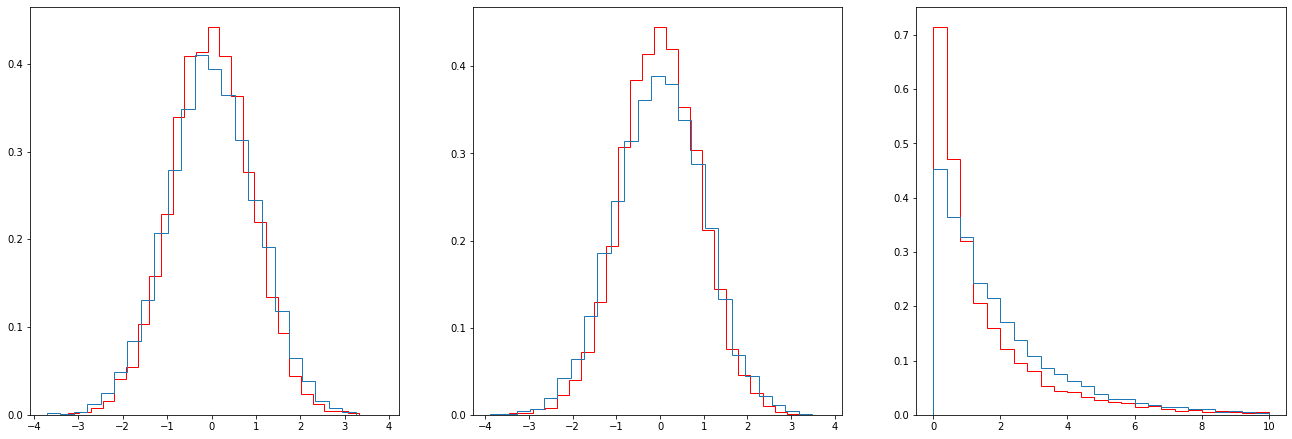

In [62]:
plt.figure(figsize=(22.5, 7.5))
plt.subplot(1, 3, 1)
plt.hist(data_signal[:,0], bins=25, histtype="step", color="red", density=True)
plt.hist(data_background[:,0], bins=25, histtype="step", density=True)

plt.subplot(1, 3, 2)
plt.hist(data_signal[:,1], bins=25, histtype="step", color="red", density=True)
plt.hist(data_background[:,1], bins=25, histtype="step", density=True)

plt.subplot(1, 3, 3)
plt.hist(np.sum(data_signal**2, axis=1), bins=25, histtype="step", color="red", range=(0,10), density=True)
plt.hist(np.sum(data_background**2, axis=1), bins=25, histtype="step", range=(0,10), density=True)
plt.show()

## Dataloader

In [ ]:
data_train = np.concatenate([data_signal[:math.ceil(0.8*len(data_signal))], data_background[:math.ceil(0.8*len(data_background))]], axis=0)
labels_train = np.concatenate([np.ones(math.ceil(0.8*len(data_signal))), np.zeros(math.ceil(0.8*len(data_background)))], axis=0)
data_val = np.concatenate([data_signal[math.ceil(0.8*len(data_signal)):], data_background[math.ceil(0.8*len(data_background))]:], axis=0)
labels_val = np.concatenate([np.ones(math.floor(0.2*len(data_signal))), np.zeros(math.floor(0.2*len(data_background)))], axis=0)


class Dataloader:
    def __init__(self, data, labels, batchsize):
        assert len(data) == len(labels), "Require the same amount of labels as data"
        self.data = data
        self.labels = labels
        self.perm = np.random.randn()

## Training

In [67]:
opt = AdamOptimizer(0.005, beta1=0.9, beta2=0.9)
model = Model()

#Initial params
v = np.random.randn(model.n_params)

n_epochs = 5
batch_size = 1024

for epoch in range(n_epochs):
    # Shuffle data
    perm = np.random.permutation(len(data_train))
    data_train = data_train[perm]
    labels_train = labels_train[perm]
    